## Emotion recognition in Songs

AGENTA:
- Feature extraction
- Label creation - preproccessing (standardizatrion, EDA,std+deltas drop, visualization)
- Feature selection (Correlation matrix OR RandomFroset)
- Data split KFold
- Oversampling with SMOTE (imbalanceness)
    -- Additional future work: data augmentation
- Training with GridSearch on SVC KFold
- Evaluation with confusion matrix + 4 tp,tn,fn,fp
- Plot ROC curve, precision and recall

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! git clone https://github.com/tyiannak/pyAudioAnalysis.git
! pip install -r /content/pyAudioAnalysis/requirements.txt


In [ ]:
!apt-get install -y ffmpeg eyed3
!pip install pyAudioAnalysis


## Choosing the dataset

Our project subject is emotion classification in songs.
For this, we decided to find a dataset that consisted of the audio files and some annotated data as well that could enrich our model to additional useful features. The dataset we came across was the DEAM dataset [SOURCE: *Aljanaki, Anna & Yang, yi-hsuan & Soleymani, Mohammad. (2017). Developing a benchmark for emotional analysis of music. PLOS ONE. 12. e0173392. 10.1371/journal.pone.0173392.*].

DEAM consists of 2058 45-sec song clips of various genres and some provided labeled data which is the metadata, audio features and the valence & arousal label values in short term wondows and long term for the whole song.
From the given dataset, only 1744/2058 were correctly and fully annotated.
Also, we decided to extract our own audio features and use only valence & arousal provided as the target labels.

The metadata files provided from DEAM were not very well annotated and needed some manual preproccessing. From the metadata datasets, we could only use one column entry, wich described the Genre of most of the annotated songs.

For our model, we used the song average values of valence and arousal that has been annotated by experts. are annotated by experts. Valence and arousal are audio properties closely related to emotion. Based on Thayer's theory, depending on the combination of values of valence and arousal of an audio signal, we can determine its emotion.
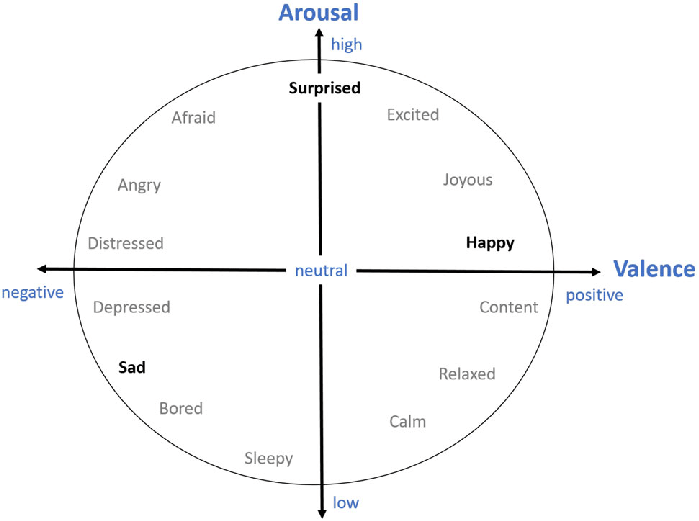


( source: Yang, yi-hsuan & Lin, Yu-Ching & Cheng, Heng-Tze & Liao, I-Bin & Ho, Yeh-Chin & Chen, Homer. (2008). Toward Multi-modal Music Emotion Classification. 70-79. 10.1007/978-3-540-89796-5_8. )

Based on these values, we extract the target labels for each emotion our model will try to predict. More on this process during the feature extraction

In [ ]:
#get the DEAM dataset from Kaggle
api_token = {"username":"lspart","key":"589f3fdd7c941d7f8b97f7e4a8423cbd"}

import json
import os

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
%mkdir data
%cd data

/content/data


In [ ]:
!kaggle datasets download -d imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music
db_ilepath = '/content/data/deam-mediaeval-dataset-emotional-analysis-in-music'
%mkdir deam-mediaeval-dataset-emotional-analysis-in-music
%mv deam-mediaeval-dataset-emotional-analysis-in-music.zip deam-mediaeval-dataset-emotional-analysis-in-music
%cd deam-mediaeval-dataset-emotional-analysis-in-music
!unzip deam-mediaeval-dataset-emotional-analysis-in-music.zip


## Feature extraction

To extract the meaningful audio features, we used pyAudioAnalysis to extract the mid term features of each song. We used the mean values of the extracted features. After testing, it was noticed that deltas values and std values were dropping the accuracy of the model, so we will preproccess the extracted features by droppping these values.

In [ ]:
# Midterm (and optional shortterm) audio feature extraction
# Given a folder of all wav or mp3 input data songs,
# call midterm feature extraction, create the pandas dataframe
# and save a csv and pkl file.
#
# If pkl already exists, load it and return the dataframe
############## DO MP3 TO WAV CONVERTION CELL FIRST

import os
import pandas as pd
from pyAudioAnalysis import MidTermFeatures as mtf
from pyAudioAnalysis import ShortTermFeatures, audioBasicIO
import pickle
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def audio_feature_extraction(deam_audio_path, pkl_path, shortTerm = False):
    all_mid_term_features = []
    all_files = []
    all_feature_names = []
    if os.path.isfile(pkl_path):
        with open(pkl_path,'rb') as f:
            mid_term_features_2 = pickle.load(f)
            ### the commented is needed for midterm_audio_full.pkl
            ## new version saved all info into one pkl->file total_data_csv
            #wav_file_list2 = pickle.load(f)
            #mid_feature_names = pickle.load(f)
            all_mid_term_features = mid_term_features_2
            print('extracted!')
            wavFeatures_df = pd.DataFrame(all_mid_term_features)

            print(wavFeatures_df.head())
    else:
        with open(pkl_path,'wb') as f:
            if shortTerm:
                    # this loop is for using ShortTermFeature. Otherwise, comment it
                j = 0
                for fille in dir:
                    # computes all audio features of wav files in given folder
                    [Fs, x] = audioBasicIO.read_audio_file(deam_audio_path + fille)
                    #print(Fs,x.shape)
                    if len(x.shape) == 1:
                        mid_term_features_2, mid_feature_names = ShortTermFeatures.feature_extraction(x, Fs, 0.08*Fs, 0.08*Fs)
                    else:
                        mid_term_features_2, mid_feature_names = ShortTermFeatures.feature_extraction(x[:,0], Fs, 0.08*Fs, 0.08*Fs)
                    #print(F.shape, feature_names, len(feature_names))

                    all_mid_term_features.append(mid_term_features_2)
                    all_feature_names.append(mid_feature_names)
                    all_files.append(fille)

                    j += 1
            else:
                mid_term_features, wav_file_list2, mid_feature_names = mtf.directory_feature_extraction(deam_audio_path ,1,1, 0.080, 0.08)
                # Append the features and file information to the lists
                print(mid_term_features, wav_file_list2, mid_feature_names)
                # Save before standardization
                wavFeatures_df = pd.DataFrame(mid_term_features)
                if shortTerm != True:
                    for i,filename in enumerate(wav_file_list2):
                        filename = filename.split('/')[-1]
                        wav_file_list2[i] = filename.split('.')[0]
                wavFeatures_df.columns = [mid_feature_names]
                wavFeatures_df['song_id'] = wav_file_list2
                ffile = open('unnormalized_midterm.pkl', 'wb')
                pickle.dump(wavFeatures_df, ffile)
                ffile.close()
                # Standardization
                m = mid_term_features.mean(axis=0)
                s = np.std(mid_term_features, axis = 0)
                print(s)
                mid_term_features_2 = (mid_term_features - m) / s
                all_mid_term_features = mid_term_features_2
                all_feature_names = mid_feature_names
                all_files = mid_feature_names

                print(all_mid_term_features, all_feature_names)
            # in shorttermffeatures, here it is an array. Change to mid_term+features_2 and wav_file_list2
            #all_mid_term_features = all_mid_term_features.reshape(-1, all_mid_term_features.shape[2])

            # we now have all sound features extracted from wav files
            # print dimensions
            print(len(all_mid_term_features))
            wavFeatures_df = pd.DataFrame(all_mid_term_features)
            # cahnge the wav_filename_list to just the filename (song_id)
            if shortTerm != True:
                for i,filename in enumerate(wav_file_list2):
                    filename = filename.split('/')[-1]
                    wav_file_list2[i] = filename.split('.')[0]

            wavFeatures_df.columns = [mid_feature_names]
            wavFeatures_df['song_id'] = wav_file_list2

            pickle.dump(wavFeatures_df, f)
            print(wavFeatures_df.head())
    wavFeatures_df.to_csv('mid_audio_full.csv')
    # create dataframe and return it
    return wavFeatures_df


### utility functions
def pkl_to_pd(pkl_path):
    with open(pkl_path,'rb') as f:
        mid_term_features_2 = pickle.load(f)
    return mid_term_features_2

def csv_to_pd(csv_path):
    return pd.read_csv(csv_path, index_col=0)
def pd_to_csv(pd_path):
    return pd.read_csv(pd_path, index_col=0)
def pd_to_pkl(dff, pkl_path):
    ffile = open(pkl_path, 'wb')
    pickle.dump(dff, ffile)
    ffile.close()

Preproccessing:

Based on the Thayer's model, we set 4 classes / emotions. Since the values of arousal and valence in theprovided DEAM annotations are in range 1-9, we set a threshold of value 5 and create a new column 'emotino' based on the values of valence and arousal around that threshold:

* happy: Valence > 5 and Arousal >5
* calm: Valence > 5 and Arousal < 5
* anger: Valence <5 and Arousal > 5
* sad: Valence < 5 and Arousal < 5


Below get_features() function returns a pandas Dataframe with all audio features and the new created column 'emotion' specifying one of the 4 above emotions based on the given arousal & valence values.

Call get_features() to immediately get the result dataframe with both audio features and labels.

In [ ]:
import pandas as pd
import os
import csv

# Creates Final CSV of audio features + valence&arousal labels
# deampath: the path of th eDEAM dataset containing
#           valence&arousal label annotations
# csv_audio_features_path: path of the extracted audio features csv
def get_features(deam_path, csv_audio_features_path):
    emotions = ["happy", # Valence > 0 and Arousal >0
        "calm"   # Valence > 0 and Arousal < 0
        "angry",  # Valence <0 and Arousal > 0
        "sad",  # Valence < 0 and Arousal < 0
    ]

    au_df = csv_to_pd(csv_audio_features_path)
    df = pd.read_csv(deam_path, usecols=['song_id', ' valence_mean', ' arousal_mean'])
    # Rename columns
    df.rename(columns = {' valence_mean':'valence'}, inplace = True)
    df.rename(columns = {' arousal_mean':'arousal'}, inplace = True)

    total_data = pd.DataFrame(au_df)

    # go row by row, coz some annotations missing from DEAM
    for indfex, row in df.iterrows():
        if row['song_id'] in total_data['song_id'].values:
            total_data.loc[total_data['song_id'].values == row['song_id'], 'valence'] = row['valence']
            total_data.loc[total_data['song_id'].values == row['song_id'], 'arousal'] = row['arousal']
    print(total_data.head())

    # create the labels
    for indfex, row in total_data.iterrows():
      if row['valence'] >= 5 and row['arousal'] >= 5:
          total_data.at[indfex, 'emotion'] = 1
      if row['valence'] >= 5 and row['arousal'] < 5:
          total_data.at[indfex, 'emotion'] = 2
      if row['valence'] < 5 and row['arousal'] >= 5:
          total_data.at[indfex, 'emotion'] = 3
      if row['valence'] < 5 and row['arousal'] < 5:
          total_data.at[indfex, 'emotion'] = 4
    print('done')

    # since some annotations were missing,
    # create a test dataset with the missing annotations
    empty_values_df = total_data[total_data['valence'].isnull()]
    empty_values_df = empty_values_df.drop(columns=['valence','arousal','emotion'])

    # and only keep fully annotated data for training
    total_data = total_data.dropna()
    TotalData_df = pd.DataFrame(total_data)
    #TotalData_df.columns = ['song',  'emotion', 'arousal', "valence"]
    TotalData_df.to_csv("total_data.csv",index=False)


    return TotalData_df, empty_values_df

Now that we have extracted our features, we split them in structures needed to define our dataset. With X we define all samples that will be used for training, validation and test and y are the target values.

In [ ]:
# Define feature data and labels
import numpy as np
import pandas as pd
feature_path = '/content/drive/MyDrive/ai_unipi/MachineLearning/media/total_annotated_data.csv'

data = csv_to_pd(feature_path)
X = np.array(data.iloc[:, :-3].values)#.T
y = np.array(data['emotion'])
y_r = np.array([data['valence'],data['arousal']])
feature_names = data.columns.values
print(X.shape)
print(feature_names)

(1744, 139)
['zcr_mean' 'energy_mean' 'energy_entropy_mean' 'spectral_centroid_mean'
 'spectral_spread_mean' 'spectral_entropy_mean' 'spectral_flux_mean'
 'spectral_rolloff_mean' 'mfcc_1_mean' 'mfcc_2_mean' 'mfcc_3_mean'
 'mfcc_4_mean' 'mfcc_5_mean' 'mfcc_6_mean' 'mfcc_7_mean' 'mfcc_8_mean'
 'mfcc_9_mean' 'mfcc_10_mean' 'mfcc_11_mean' 'mfcc_12_mean' 'mfcc_13_mean'
 'chroma_1_mean' 'chroma_2_mean' 'chroma_3_mean' 'chroma_4_mean'
 'chroma_5_mean' 'chroma_6_mean' 'chroma_7_mean' 'chroma_8_mean'
 'chroma_9_mean' 'chroma_10_mean' 'chroma_11_mean' 'chroma_12_mean'
 'chroma_std_mean' 'delta zcr_mean' 'delta energy_mean'
 'delta energy_entropy_mean' 'delta spectral_centroid_mean'
 'delta spectral_spread_mean' 'delta spectral_entropy_mean'
 'delta spectral_flux_mean' 'delta spectral_rolloff_mean'
 'delta mfcc_1_mean' 'delta mfcc_2_mean' 'delta mfcc_3_mean'
 'delta mfcc_4_mean' 'delta mfcc_5_mean' 'delta mfcc_6_mean'
 'delta mfcc_7_mean' 'delta mfcc_8_mean' 'delta mfcc_9_mean'
 'delta mfcc_10_me

**Visualizing the emotion count of all the songs in the dataset.**

To get a better understanding of the distribution of our dataset, we will plot the class count of all samples.

It looks like the class for happy and angry are outweighing the other 2 classes. We have around 11% of coverage for each of the other weaker classes. This means, there is a medium level of **imbalanceness**!
To solve this issue, we will use simple oversampling on the weaker classes (2 and 3) and will also try random under sampling on the prominent ones.


This will be shown during the train-test split later.

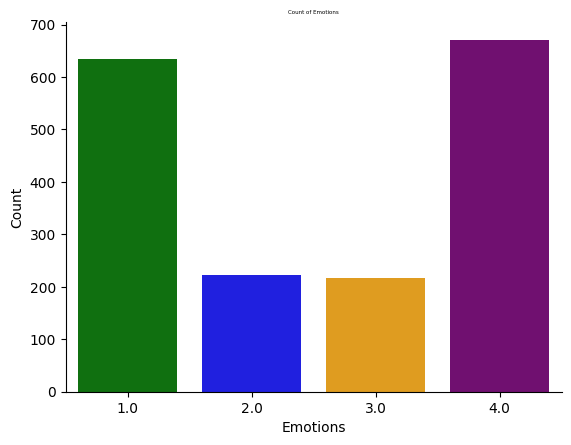

In [ ]:
### Visualizing different labels count
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=4)
sns.countplot(x='emotion', data=data, palette=['green', 'blue', 'orange', 'purple'])
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

## Feature selection

* Our data consists of around 140 features -- this is a lot!
* Not all features contriubute the same in the final result

For this reason, in order to find the most meaningful features, we applied several methods, Correlation matrix filtering, mRMR and also 3 different regressors: Logistic, Decision and RandomForest.

From all the feature selection methods, the **RandomForest Classifier** gave the best results while usign its features during training.


Another thing we noticed during training is that filtering our the STD and deltas values from the audio extraction also gave a bit better result in the accuracy.

**FINAL PREPROCCESSED DATA:**

Our final preproccessing for feature selection includes removal of std + delta values and from the ones left filtering to the top 20 most important feeatures. This shapes our final dataset.



In [ ]:
## dataset without the std values
filter_columns = list(range(0, 67)) + list(range(136, 141))
print(data.shape)
midterm_mean = data.iloc[:, filter_columns].copy()
## dataset without the deltas and std values (short term features)
filter_columns = list(range(0, 34)) + list(range(136, 141))
short_term = data.iloc[:, filter_columns].copy()

midterm_mean.to_csv("/content/drive/MyDrive/ai_unipi/MachineLearning/media/total_data_no_std.csv",index=False)
short_term.to_csv("/content/drive/MyDrive/ai_unipi/MachineLearning/media/total_data_no_std_no_deltas.csv",index=False)

X_means = np.array(short_term.iloc[:, :-3].values)#.T
y_means = np.array(data['emotion'])
y_means_r = np.array([short_term['valence'],short_term['arousal']])

no_std = 2
if no_std == 2:
    X = X_means
    y = y_means
    y_r = y_means_r

print(X.shape)

(1744, 142)
(1744, 36)


In [ ]:
# final preproccessed dataset
short_term.iloc[:, :-3]

,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,...,chroma_6_mean,chroma_7_mean,chroma_8_mean,chroma_9_mean,chroma_10_mean,chroma_11_mean,chroma_12_mean,chroma_std_mean,bpm,ratio
0,-0.174710,-0.774566,0.030276,-0.200111,-0.004680,-0.193153,0.864971,-0.282300,-0.876862,0.073389,...,0.193813,0.206704,0.012927,-0.227592,-0.122758,-0.297366,-0.308267,0.036901,1.724055,-0.305389
1,0.380791,1.045841,0.365854,0.377840,0.217572,0.305879,-0.469400,0.270129,1.256673,-0.584797,...,0.101932,-0.646363,-0.163170,-0.576274,-0.425148,0.677185,-0.621250,-0.026535,0.084761,0.379391
2,0.292477,-0.063243,0.840085,-0.128733,-0.409315,0.145741,-0.818416,0.356293,0.946473,-0.542595,...,-0.121987,0.883973,-0.319942,-0.943038,-0.256045,-0.795179,-0.219743,-1.034127,-0.383609,-0.183832
3,-0.983304,-1.044797,-0.374764,-0.806344,-0.071832,-0.846609,1.969040,-0.845289,-2.637234,1.081280,...,0.735090,-0.438844,-0.289533,1.113822,0.211428,0.509506,0.525837,1.490611,0.740479,-0.560611
4,-0.344802,-1.084248,-2.433123,0.231515,0.188764,0.176503,2.567123,0.257278,-2.457387,-0.012022,...,-0.166204,-0.023060,-0.696779,-1.176260,-0.644117,-1.073923,-0.216960,-0.105543,1.724055,0.492607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,0.838604,1.993246,-1.710779,2.109487,2.720483,0.687204,-0.177089,0.821288,1.193196,-0.277248,...,-0.141343,-0.111968,0.324204,0.709183,-0.230099,0.299772,-0.446246,-0.503256,-0.734887,-0.449304
1798,1.366235,-0.556953,1.202746,1.035852,0.690771,1.493685,-1.174024,1.181664,0.907262,-0.949729,...,-0.932308,-0.572279,-1.021814,-1.062896,0.147244,0.147417,1.850628,-1.347832,0.084761,0.894322
1799,0.785507,0.004841,-0.740913,0.238785,-0.651252,1.272343,-0.707278,0.798689,0.735869,-1.329181,...,-0.409976,-0.232239,-0.494367,-0.234539,-0.214052,-0.110873,-0.112775,-0.820886,-0.383609,0.856923
1800,0.487497,0.439203,-1.930553,-0.036658,-1.015471,1.010040,-0.584056,0.523388,0.817299,-0.654992,...,-0.449520,-0.768251,1.118263,-0.011360,0.780202,-0.554736,-0.419202,-0.473159,-0.383609,-0.524316


### Correlation matrix between input features

https://www.kaggle.com/code/bbloggsbott/feature-selection-correlation-and-p-value

We will find the correlation value between features vs features and features vs label. The higher the correlation between features is, the less important they are, while the opposite is true for feature vs label.

* 0.9 to 1 or -0.9 to -1 --> Perfect Correlation

* 0.5 to 0.9 or -0.5 to -0.9 --> Strong

* 0.1 to 0.5 or -0.1 to -0.5 --> Weak

* 0.0 to 0.1 or 0.0 to -0.1 --> Uncorrelated

Dataset after 38
Dataset after 119


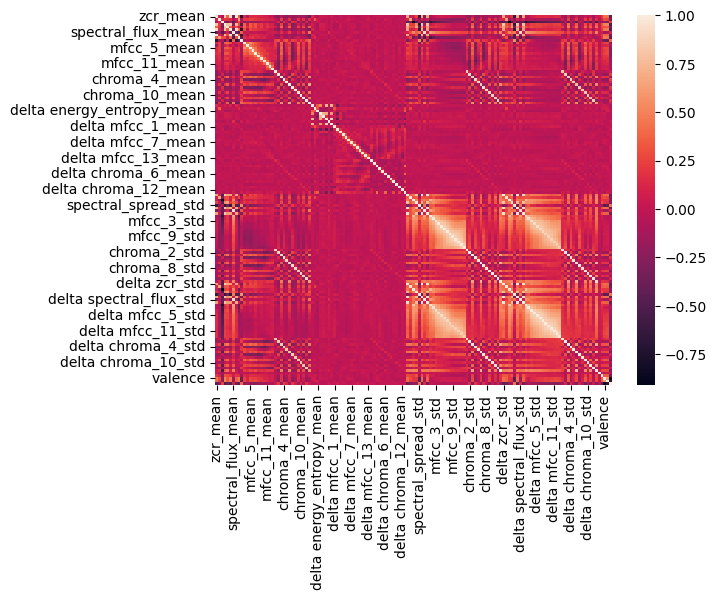

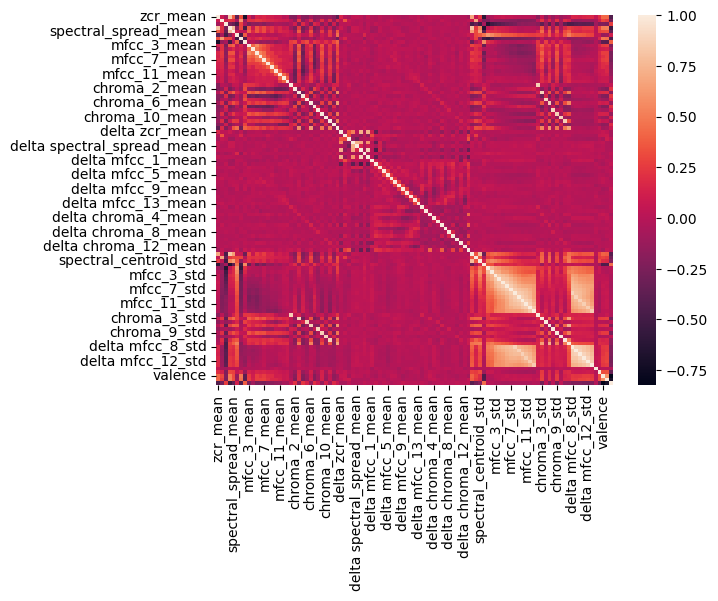

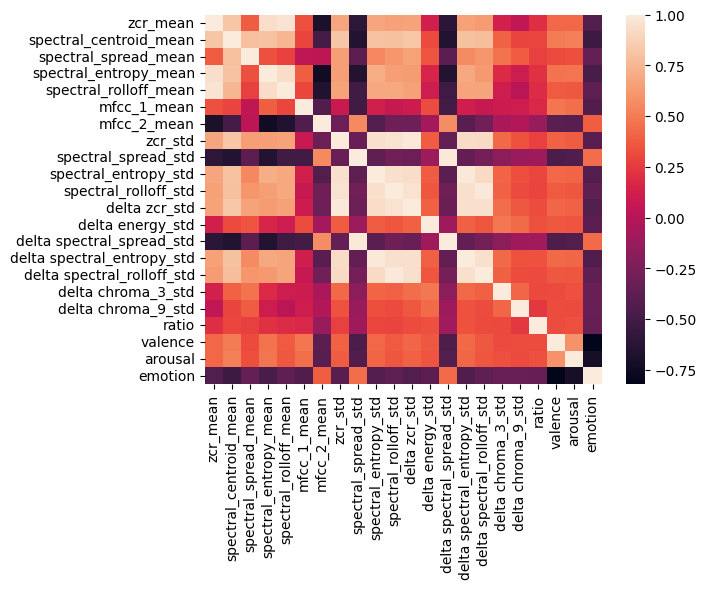

<Figure size 640x480 with 0 Axes>

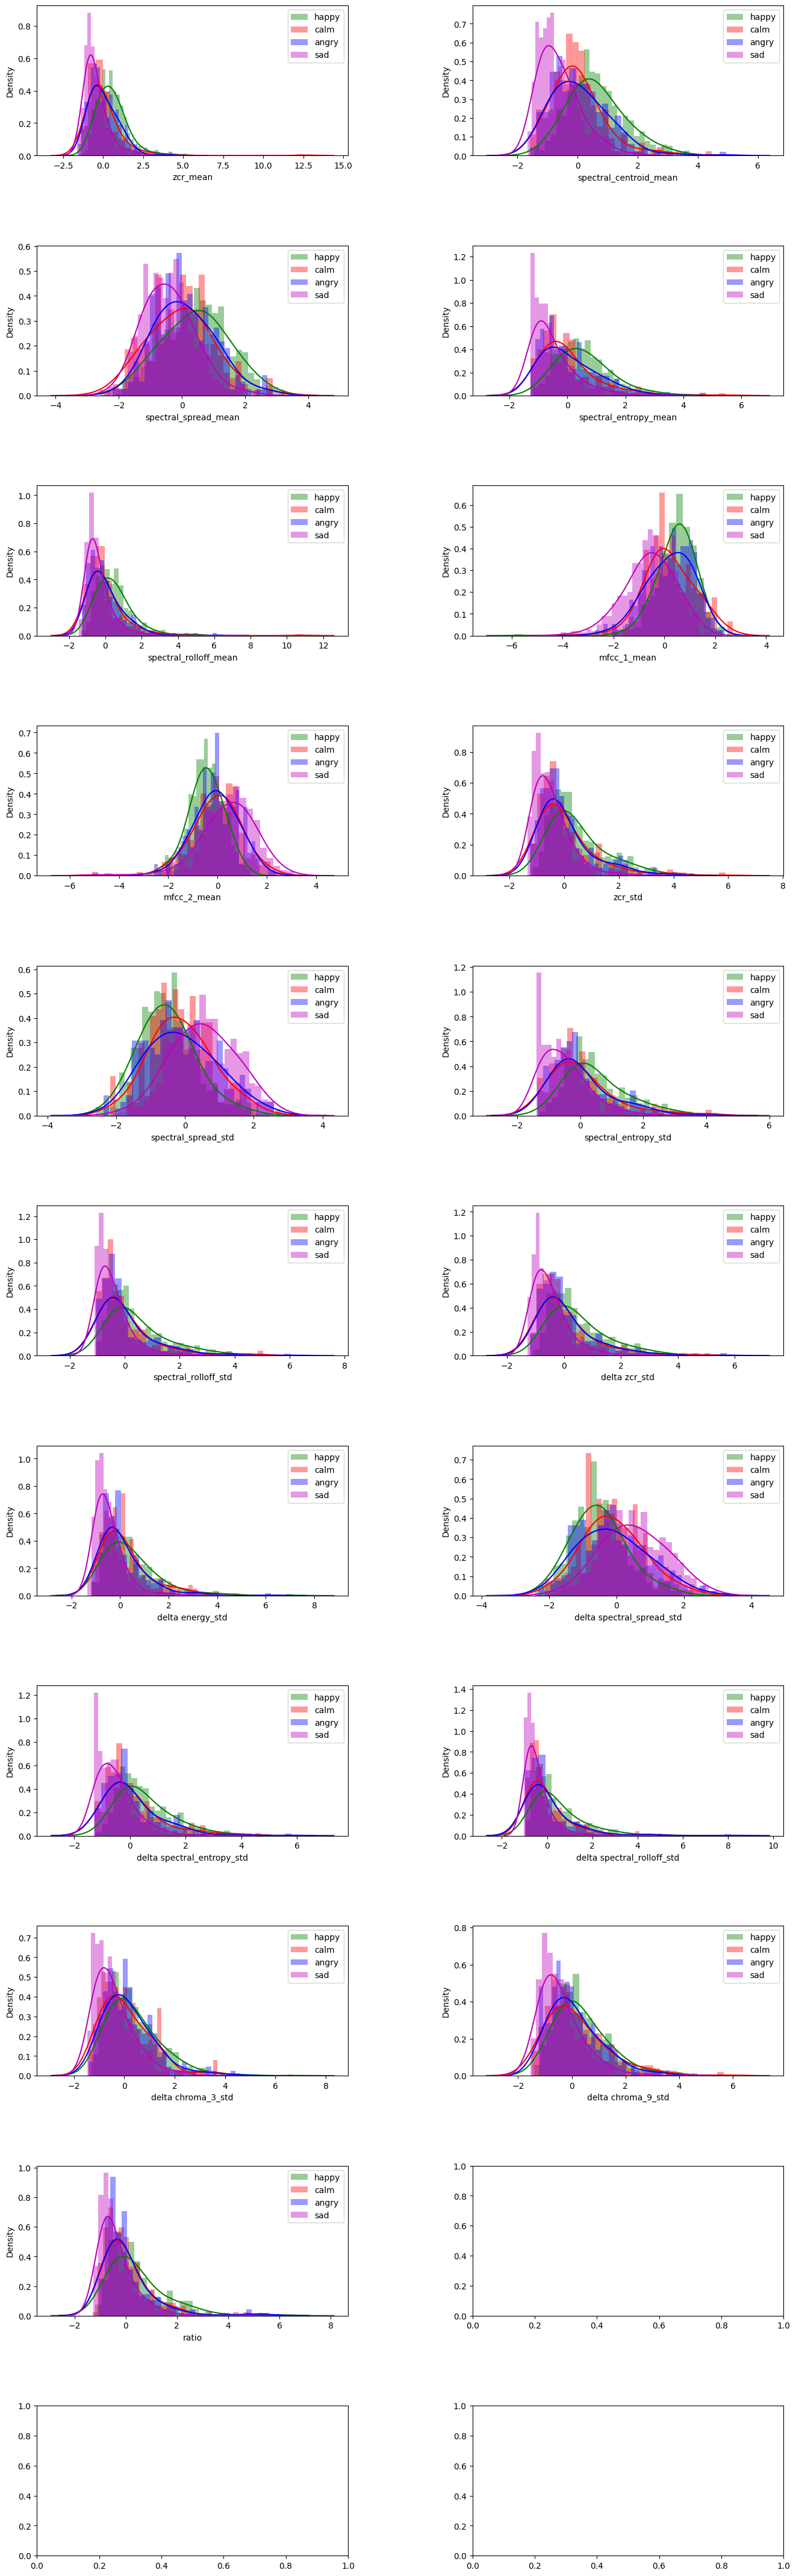

Selecting features...
(1744,) (1744, 19)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

np.random.seed(123)

no_deltas = False
if no_deltas == True:
    data = short_term
else:
    # this is the csv we extracted in previous step.
    # it contains all audio and valence&arousal features
    data = csv_to_pd(feature_path)
    data = data.drop(columns=['song_id'])

###STEP1 FEATURES VS FEATURES::::
#get correlation matrix
plt.figure()
corr = data.corr()
# Generate correlation heatmap
sns.heatmap(corr)
plt.figure()

# filter the values: because we have too many fearues (130x130) approximate matrix!
# we cannot conclude by looking at the heatmap.
# so, set a threshold for which we will consider the features
num_of_feats = corr.shape[0]
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
# Get selected cols
selected_columns = data.columns[columns]
data1 = data[selected_columns]
corr1 = data1.corr()
print(f'Dataset after { len(data.columns) - len(selected_columns) }')
sns.heatmap(corr1)
plt.figure()

###STEP2 FEATURES VS LABELS::::
#get features with high correlation to the labels
corr_matrix = data.corr()
corr_matrix["emotion"].sort_values(ascending=False)

num_of_feats = corr_matrix.shape[0]
columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
label_column = corr_matrix.iloc[:, -1]
for i in range(corr_matrix.shape[0]):
    if abs(label_column[i]) <= 0.3:
            columns[i] = False

# Get selected cols
selected_columnsf = data.columns[columns]
data2 = data[selected_columnsf]
corr2 = data2.corr()
print(f'Dataset after {len(data.columns) - len(selected_columnsf) }')
sns.heatmap(corr2)
plt.show()
plt.figure()

#### PLOT THE DISTRIBUTION OF EACH SELECTED FEATURE
result = pd.DataFrame()
result['emotion'] = data.iloc[:,-1]
j = 1
subrows = (len(data2.columns) + 1) // 2
fig, axs = plt.subplots(subrows, 2, figsize=(16, 5*subrows))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for i in data2.columns[:-3]:
    plt.subplot(subrows, 2, j)
    sns.distplot(data2[i][result['emotion']==1], color='g', label = 'happy', bins=30, kde_kws={'bw': 0.5})
    sns.distplot(data2[i][result['emotion']==2], color='r', label = 'calm', bins=30, kde_kws={'bw': 0.5})
    sns.distplot(data2[i][result['emotion']==3], color='b', label = 'angry', bins=30, kde_kws={'bw': 0.5})
    sns.distplot(data2[i][result['emotion']==4], color='m', label = 'sad', bins=30, kde_kws={'bw': 0.5})
    plt.legend(loc='best')
    j += 1

plt.show()
# Selecting useful features from training and test data
# if datta=1, take the filttered features from features vs features
# else from features vs labels
datta = 2
if datta == 1:
    X_filtered = np.array(data1.iloc[:, :-3].values)#.T
    y_filtered = np.array(data1['emotion'])
    y_full_filtered = np.array([data1['valence'],data1['arousal']])
else:
    X_filtered = np.array(data2.iloc[:, :-3].values)#.T
    y_filtered = np.array(data2['emotion'])
    y_full_filtered = np.array([data2['valence'],data2['arousal']])
print('Selecting features...')
print(y_filtered.shape, X_filtered.shape)


### RandomForestClassifier Feature Selection

Best Accuracy: 0.6619 achieved with 47 features.


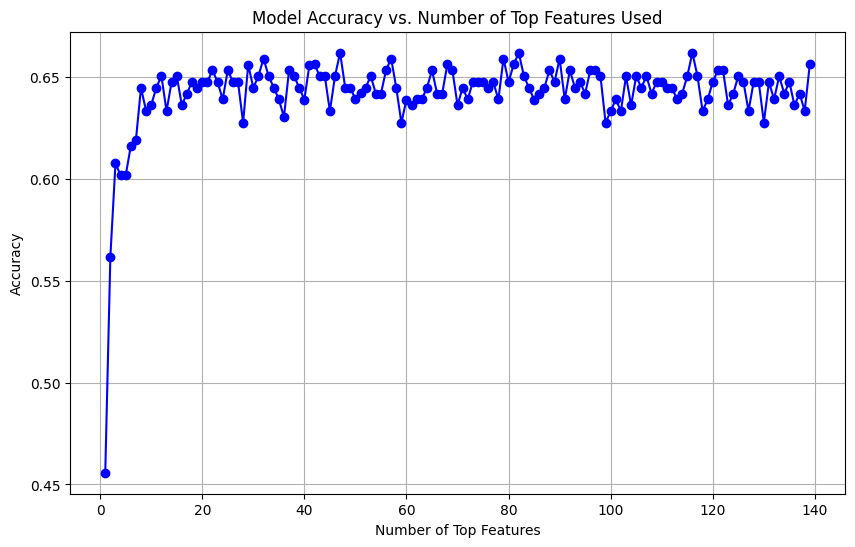

In [ ]:
### RandomForest CLassifier feature selection

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt


X = data.iloc[:, :-3]
y = data['emotion']
y_r = [data['valence'],data['arousal']]
# Train a Random Forest classifier to get feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Extracting feature importance and sorting features
features = X.columns
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Initialize variables to track the best performance
best_accuracy = 0
best_n_features = 0
accuracies = []


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Iteratively evaluate model performance with an increasing number of top features
for n_features in range(1, len(features) + 1):
    top_n_features = feature_importance_df['Feature'].head(n_features).values

    # Selecting the top N features for training and testing
    X_train_selected = X_train[top_n_features]
    X_test_selected = X_test[top_n_features]

    # Reinitialize the model to train with the top N features
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_selected, y_train)

    # Use cross-validation to evaluate the model
    scores = cross_val_score(model, X_test_selected, y_test, cv=5, scoring='accuracy')
    current_accuracy = np.mean(scores)

    # Update best performance metrics
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_n_features = n_features

    # Store accuracy for potential plotting
    accuracies.append(current_accuracy)

print(f'Best Accuracy: {best_accuracy:.4f} achieved with {best_n_features} features.')

# Plotting the accuracies to visualize the performance trend
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(features) + 1), accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Number of Top Features Used')
plt.xlabel('Number of Top Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

After finding the top 20 features extracted from RandomForest Classifier, we recollect our X data samples to filter only these features from the initial dataset:

In [ ]:
# After finding the best number of features, retrain to get the feature importances

top_features = feature_importance_df['Feature'].head(best_n_features).values

# Now use the entire dataset to filter only those top features
X_filtered = data[top_features]
#X_filtered['emotion'] = data['emotion']
y_filtered = y

#X_filtered.to_csv("/content/drive/MyDrive/ai_unipi/MachineLearning/media/top_20_X.csv", index=False)

## Data split



Our dataset is consists of songs of different kind of genres with each genre having different emotions and as depicted earlier, all classes seem well distributed.

To split the dataset to train and test datasets, we will use repeated KFold method to also do cross-validation on the dataset.

We divide the dataset to:
* 80% training dataset
* 10% validation dataset
* 10% testing dataset

For our initial split, we use stratify split on our targets.

In [ ]:
#### COME HERE AFTER FEATURE SELECTION (for better results) -- X_filtered
# Do not random split -
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_filtered, y_filtered, random_state=0, shuffle=True, test_size = 0.10, stratify=y_filtered)
print('X initial data =', X.shape, ', X_train size =', x_train.shape, ', x_test size =', x_test.shape)
# validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.12, random_state=1)
print('X_train size =', x_train.shape, ', x_val size =', x_val.shape)


X initial data = (1744, 139) , X_train size = (1569, 47) , x_test size = (175, 47)
X_train size = (1380, 47) , x_val size = (189, 47)


### Dealing with Imbalanced dataset

As mentioned, our dataset suffers from imbalance. To help with that, we apply SMOTE oversampling technique on our weak classes **after splitting** on our training dataset.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Oversampling
sm = SMOTE(random_state=42)
X_oversampled, y_oversampled = sm.fit_resample(x_train, y_train)
print('After oversampling dataset shape %s' % Counter(y_oversampled))

x_train = X_oversampled
y_train = y_oversampled

After oversampling dataset shape Counter({2.0: 529, 4.0: 529, 1.0: 529, 3.0: 529})


## Training
Classification to label 'emotion' with acoustic features.

Use of RepeatedKFold cross-validation with SVC model for classification.
For each fold, we save the accuracy, f1 score and after trainig we plot the means of these evaluation metrics.

Possible model types trained:
* Simple SVC
* KFold SVC
* RepeatKFold SVC
* Simple RandomForest
* KFold RandomForest

**Additionaly:**

Best accuracy with **Hyperparameter tuning**:

Applying cross-validation with GridSearch for finding best hyperparameters on the training model.


**BEST MODEL:** KFold GridSearch with RandomFroest classifier


For clarity, we will only display an SVC and the best performing model in the training proccess only to make the comparison between their accuracy visible.



In [ ]:
# Stratified KFold shufflesplit gridsearch
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf', 'poly']
}

clf = SVC(probability=True)
k_fold = KFold(n_splits=3, shuffle=True, random_state=42)  # Define your k value
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=k_fold, scoring='accuracy')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(x_test)
# Obtain the predicted probabilities for the test set
y_probabilities = best_model.predict_proba(x_test)

validation_accuracy = best_model.score(x_test, y_test)
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Test Accuracy:", validation_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score: 0.8083903328773371
Test Accuracy: 0.5771428571428572
Classification Report:
              precision    recall  f1-score   support

         1.0       0.71      0.72      0.72        72
         2.0       0.20      0.14      0.17        21
         3.0       0.11      0.10      0.11        20
         4.0       0.64      0.71      0.67        62

    accuracy                           0.58       175
   macro avg       0.42      0.42      0.42       175
weighted avg       0.56      0.58      0.57       175



FINAL MODEL

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
from itertools import cycle
from sklearn.svm import SVC

# Define the parameter grid for Random Forest
param_gridrf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
# Create a pipeline that first applies SMOTE and then fits the Random Forest classifier
pipeline = Pipeline([
    ('oversample', SMOTE(random_state=42)),
    ('classifier', rf)
])

# Define the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Initialize the Grid Search model with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_gridrf, cv=kf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(x_test)
y_train_pred = best_model.predict(x_train)
# Obtain the predicted probabilities for the test set
y_probabilities = best_model.predict_proba(x_test)

validation_accuracy = best_model.score(x_test, y_test)
training_accuracy = best_model.score(x_train, y_train)
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Test Accuracy:", validation_accuracy)
print("Training Accuracy:", training_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best Score: 0.7939537891966635
Test Accuracy: 0.6514285714285715
Training Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

         1.0       0.73      0.75      0.74        64
         2.0       0.38      0.36      0.37        22
         3.0       0.20      0.14      0.16        22
         4.0       0.75      0.82      0.79        67

    accuracy                           0.65       175
   macro avg       0.52      0.52      0.51       175
weighted avg       0.63      0.65      0.64       175



**Notes:**

Without imbalance split techniques, we got a far better accuracy score ~70% (compared to 60% with oversampling)

After evaluating our model in the next step we noticed however that this accuracy score was misleading, due to mere overpopulation of the prominent classes that we get correct predictions, while the classes that are not prominent never get predicted (falsenegative).

---

So we will still continue with the oversampling technique even if it seems to negatively affect our model. With oversampling, the percentage of accuracies for training and testing are also a bit more balanced and shows that there is a better bias-variance trade-off.



## Evaluation


To evaluate our classifier's accuracy, we calculate the Confusion Matrix as a visualization method on the predicted and real labels of the test dataseet:

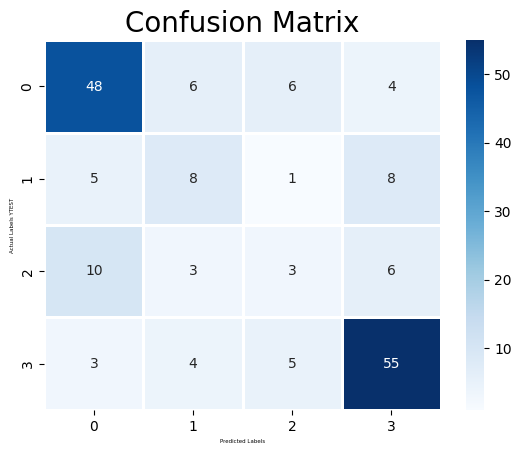

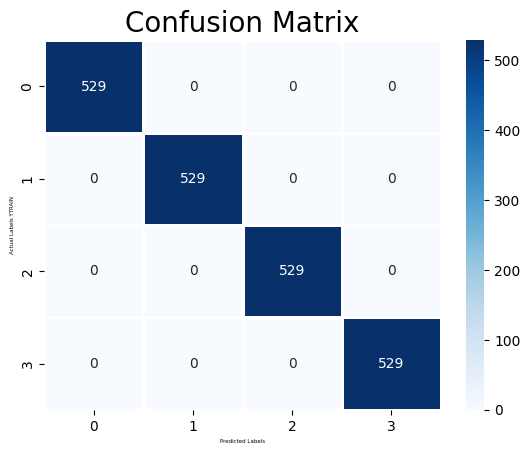

In [ ]:
###### RANDOMFOREST EVALUATION
emotions = {1:"happy", 2:"calm", 3:"angry", 4:"sad"}
## Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
#cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=4)
plt.ylabel('Actual Labels YTEST', size=4)
plt.show()

cm = confusion_matrix(y_train, y_train_pred)
#cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=4)
plt.ylabel('Actual Labels YTRAIN', size=4)
plt.show()


### ROC-AUC and Precision-Recall Curves
The ROC/ AUC evaluation is used mainly for classifying the performance between different models. The higher the accuracy, the higher in the Y axis the curve will be.
Precision-Recal is a similar evaluation estimation, where again the higher the curve, the better the accuracy


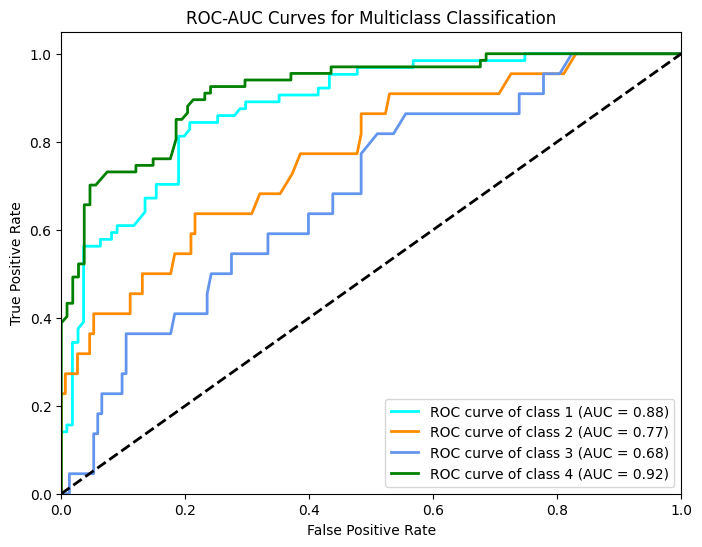

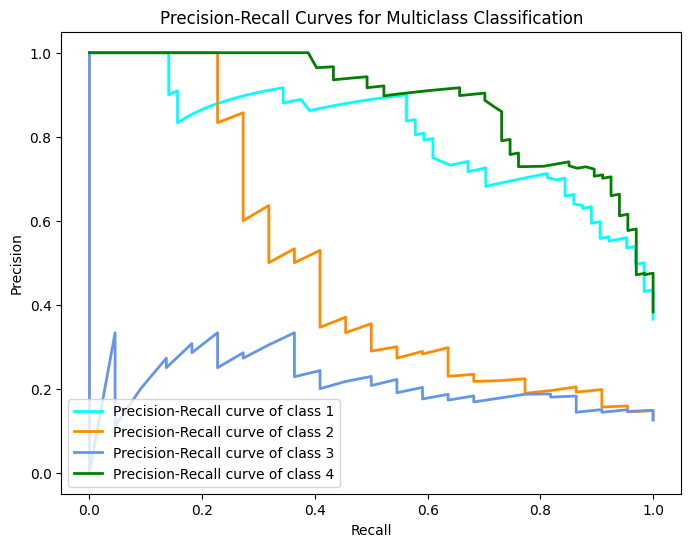

In [ ]:
#### randomforest
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle
n_classes = 4  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
thresholds = dict()
y_test_binary = label_binarize(y_test,classes=[1, 2, 3, 4])  # Binarize the true labels
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_binary[:, i], y_probabilities[:, i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

# Plot precision recal
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-Recall curve of class {0}'.format(i+1))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multiclass Classification')
plt.legend(loc="lower left")
plt.show()

CONCLUSION::

As we have seen from the results, even after all techniques used to optimize the results, the accuracy scores for the less prominent classes are still comparably low.

In general, we managed a best score of 79% accuracy.
What we could do to improve in the future is probably use data augmentation techniques for the weaker class data instead of oversampling.